# 1. NLP

Librerías

In [1]:
import json
from os.path import join
from random import shuffle, sample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict
import evaluate
import accelerate
import torch

c:\Users\arj97\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Transformación mensajes

In [3]:
ruta = "G:/Mi unidad/Prueba Bancolombia/"

def to_single_message_format(gamefile):
    messages = []
    with open(gamefile) as inh:
        for ln in inh:
            conversation = json.loads(ln)
            for msg, sender_label, receiver_label, score_delta \
                in zip(conversation['messages'],conversation['sender_labels'], \
                    conversation['receiver_labels'], conversation['game_score_delta']):
                messages.append({'message': msg, 'receiver_annotation': receiver_label,\
                    'sender_annotation':sender_label, 'score_delta': int(score_delta)})
    shuffle(messages)
    return messages

def write_single_messages(messages, outfile):
    with open(outfile, "w") as outh:
        for msg in messages:
            outh.write(json.dumps(msg)+'\n')

if __name__ == '__main__':
    ROOT = ruta

    write_single_messages(to_single_message_format(join(ruta, 'validation.jsonl')),
                                                        join(ruta, 'validation_sm.jsonl'))
    write_single_messages(to_single_message_format(join(ruta, 'train.jsonl')),
                                                        join(ruta, 'train_sm.jsonl'))
    write_single_messages(to_single_message_format(join(ruta, 'test.jsonl')),
                                                        join(ruta, 'test_sm.jsonl'))

In [2]:
ruta = "G:/Mi unidad/Prueba Bancolombia/"

train = pd.read_json(ruta+'train_sm.jsonl', orient='records', lines=True)
test = pd.read_json(ruta+'test_sm.jsonl', orient='records', lines=True)
validation = pd.read_json(ruta+'validation_sm.jsonl', orient='records', lines=True)

## EDA

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   message              13132 non-null  object
 1   receiver_annotation  13132 non-null  object
 2   sender_annotation    13132 non-null  bool  
 3   score_delta          13132 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 320.7+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2741 entries, 0 to 2740
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   message              2741 non-null   object
 1   receiver_annotation  2741 non-null   object
 2   sender_annotation    2741 non-null   bool  
 3   score_delta          2741 non-null   int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 67.0+ KB


In [13]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   message              1416 non-null   object
 1   receiver_annotation  1416 non-null   object
 2   sender_annotation    1416 non-null   bool  
 3   score_delta          1416 non-null   int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 34.7+ KB


In [14]:
df = pd.concat([train, validation, test], axis=0, ignore_index=True)

In [15]:
# Descargar recursos necesarios de nltk
nltk.download('punkt')
nltk.download('stopwords')

# Función para limpiar el texto
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = ''.join([char for char in text if char not in string.punctuation])
    # Eliminación específica
    text = text.replace('’', '').replace('im', '')
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar palabras vacías
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_messages'] = df['message'].apply(clean_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arj97\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arj97\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [16]:
# Análisis de longitud de los mensajes
df['message_length'] = df['cleaned_messages'].apply(len)

df['message_length'].describe()

count    17289.000000
mean        63.194459
std         67.767322
min          0.000000
25%         21.000000
50%         43.000000
75%         82.000000
max        915.000000
Name: message_length, dtype: float64

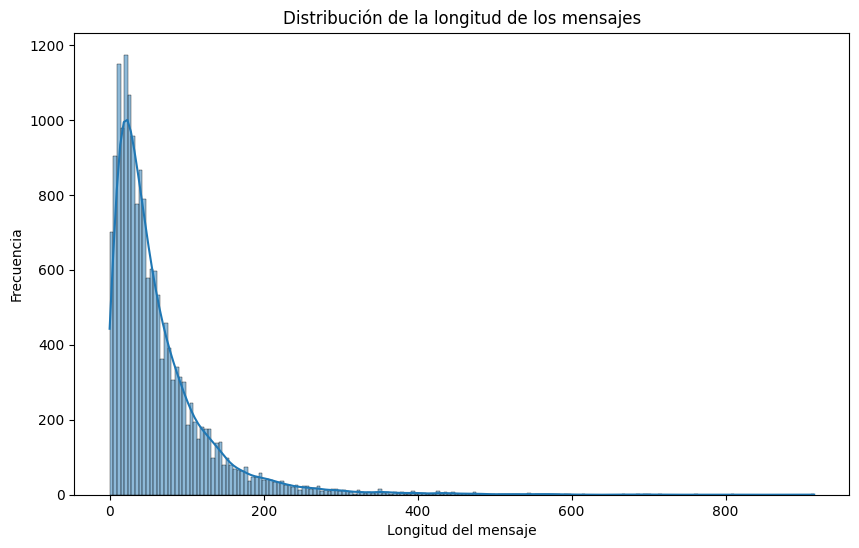

In [17]:
# Gráfico de distribución de la longitud de los mensajes
plt.figure(figsize=(10, 6))
sns.histplot(df['message_length'], kde=True)
plt.title('Distribución de la longitud de los mensajes')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.show()

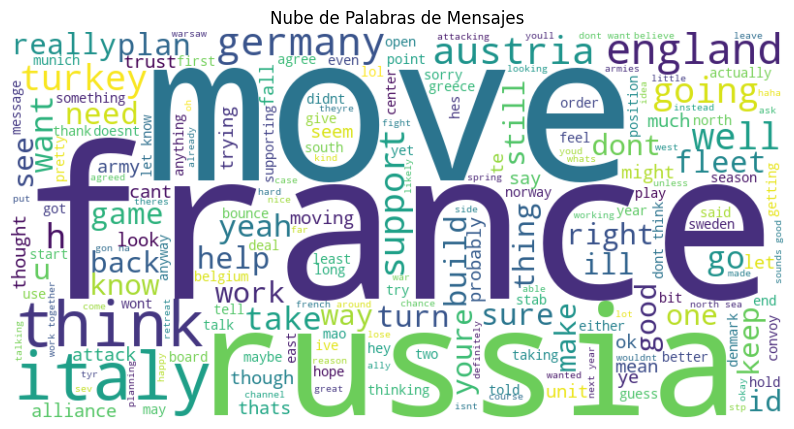

In [18]:
# Generar una nube de palabras
text = ' '.join(df['cleaned_messages'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Mensajes')
plt.show()

        word  frequency
38     would       1852
152    think       1807
90    france       1668
232   russia       1609
94   support       1539
22     italy       1501
18      like       1472
253      get       1456
89   england       1455
92      move       1380


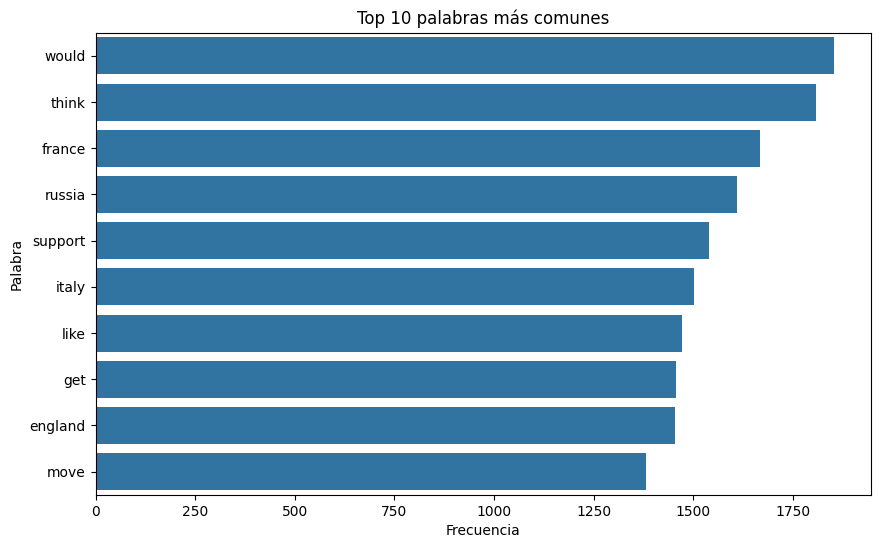

In [19]:
# Contar las palabras
words = text.split()
word_freq = Counter(words)

# Convertir a DataFrame para visualizar
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Mostrar las palabras más comunes
print(word_freq_df.head(10))

# Gráfico de las palabras más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=word_freq_df.head(10))
plt.title('Top 10 palabras más comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

## Modelo

Modelo base

In [3]:
check_point = "hamzab/roberta-fake-news-classification"
tokenizer = AutoTokenizer.from_pretrained(check_point)
model = AutoModelForSequenceClassification.from_pretrained(check_point,num_labels=2)
task = pipeline("text-classification",model = model, tokenizer=tokenizer, padding="max_length", truncation=True, device="cuda")
pred = test["message"].apply(lambda x: dict(*task(str(x)))["label"])
test_b = test['sender_annotation'].replace({True:"TRUE",False:"FAKE"})
print(classification_report(test_b,pred))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


              precision    recall  f1-score   support

        FAKE       0.09      0.94      0.16       240
        TRUE       0.84      0.03      0.05      2501

    accuracy                           0.11      2741
   macro avg       0.46      0.49      0.11      2741
weighted avg       0.77      0.11      0.06      2741



Modelo con Transfer Learning

In [4]:
check_point = "hamzab/roberta-fake-news-classification"
tokenizer = AutoTokenizer.from_pretrained(check_point)
model = AutoModelForSequenceClassification.from_pretrained(check_point, num_labels=2)

In [5]:
#Convertir a Dataset
train = train[['message', 'sender_annotation']]
test = test[['message', 'sender_annotation']]
validation = validation[['message', 'sender_annotation']]
train = train.rename(columns={'sender_annotation':'label', 'message':'text'})
test = test.rename(columns={'sender_annotation':'label', 'message':'text'})
validation = validation.rename(columns={'sender_annotation':'label', 'message':'text'})
train['label'] = train['label'].replace({True:0,False:1})
test['label'] = test['label'].replace({True:0,False:1})
validation['label'] = validation['label'].replace({True:0,False:1})
train_ds = Dataset.from_pandas(train,preserve_index=False)
test_ds = Dataset.from_pandas(test,preserve_index=False)
validation_ds = Dataset.from_pandas(validation,preserve_index=False)

C:\Users\arj97\AppData\Local\Temp\ipykernel_27032\1964735783.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['label'] = train['label'].replace({True:0,False:1})
C:\Users\arj97\AppData\Local\Temp\ipykernel_27032\1964735783.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['label'] = test['label'].replace({True:0,False:1})
C:\Users\arj97\AppData\Local\Temp\ipykernel_27032\1964735783.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavi

In [6]:
#Tokenizar Dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True,max_length=128)
dataset = DatasetDict({
    'train': train_ds,
    'test': test_ds,
    'dev': validation_ds})
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1416/1416 [00:00<00:00, 22649.95 examples/s]


In [7]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
training_args = TrainingArguments(output_dir="./model_local",
                                    eval_strategy="epoch",
                                    auto_find_batch_size=True,
                                    num_train_epochs=5,
                                    save_strategy = "epoch",
                                    load_best_model_at_end=True,
                                    learning_rate=2e-5,
                                    weight_decay=0.01,
                                    max_grad_norm=1.0,
                                    save_only_model=True,
                                    resume_from_checkpoint=True,
                                    overwrite_output_dir=True,
                                    metric_for_best_model="eval_loss"
                                    )

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    compute_metrics=compute_metrics
)
trainer.train()

  6%|▌         | 501/8210 [00:57<15:05,  8.51it/s]

{'loss': 0.221, 'grad_norm': 0.38215386867523193, 'learning_rate': 1.8781973203410477e-05, 'epoch': 0.3}


 12%|█▏        | 1001/8210 [01:53<13:44,  8.74it/s]

{'loss': 0.1799, 'grad_norm': 0.36785373091697693, 'learning_rate': 1.756394640682095e-05, 'epoch': 0.61}


 18%|█▊        | 1501/8210 [02:51<12:46,  8.76it/s]

{'loss': 0.2052, 'grad_norm': 3.496082305908203, 'learning_rate': 1.6345919610231427e-05, 'epoch': 0.91}


 20%|█▉        | 1641/8210 [03:07<12:19,  8.88it/s]













































                                           
                                                   
 20%|██        | 1642/8210 [03:12<12:19,  8.88it/s]


{'eval_loss': 0.18237364292144775, 'eval_f1': 0.0, 'eval_runtime': 5.1888, 'eval_samples_per_second': 272.897, 'eval_steps_per_second': 34.112, 'epoch': 1.0}


 24%|██▍       | 2002/8210 [03:54<11:46,  8.79it/s]

{'loss': 0.2006, 'grad_norm': 3.571937084197998, 'learning_rate': 1.5127892813641902e-05, 'epoch': 1.22}


 30%|███       | 2502/8210 [04:51<10:42,  8.88it/s]

{'loss': 0.1918, 'grad_norm': 0.37326884269714355, 'learning_rate': 1.3909866017052377e-05, 'epoch': 1.52}


 37%|███▋      | 3002/8210 [05:48<09:58,  8.70it/s]

{'loss': 0.2036, 'grad_norm': 0.3792796730995178, 'learning_rate': 1.2691839220462852e-05, 'epoch': 1.83}


 40%|███▉      | 3283/8210 [06:19<09:24,  8.73it/s]












































                                                   

 40%|████      | 3284/8210 [06:25<09:24,  8.73it/s]



{'eval_loss': 0.17792074382305145, 'eval_f1': 0.0, 'eval_runtime': 5.2905, 'eval_samples_per_second': 267.651, 'eval_steps_per_second': 33.456, 'epoch': 2.0}


 43%|████▎     | 3502/8210 [06:51<08:51,  8.86it/s]

{'loss': 0.231, 'grad_norm': 0.4797605276107788, 'learning_rate': 1.1473812423873325e-05, 'epoch': 2.13}


 49%|████▊     | 4001/8210 [07:47<08:01,  8.75it/s]

{'loss': 0.2003, 'grad_norm': 0.3670017421245575, 'learning_rate': 1.0255785627283802e-05, 'epoch': 2.44}


 55%|█████▍    | 4501/8210 [08:44<07:00,  8.82it/s]

{'loss': 0.2065, 'grad_norm': 0.44865310192108154, 'learning_rate': 9.037758830694277e-06, 'epoch': 2.74}


 60%|█████▉    | 4925/8210 [09:31<06:13,  8.81it/s]












































                                                   

 60%|██████    | 4926/8210 [09:37<06:12,  8.81it/s]



{'eval_loss': 0.18679578602313995, 'eval_f1': 0.0, 'eval_runtime': 5.2855, 'eval_samples_per_second': 267.901, 'eval_steps_per_second': 33.488, 'epoch': 3.0}


 61%|██████    | 5001/8210 [09:47<06:20,  8.44it/s]

{'loss': 0.205, 'grad_norm': 3.4227867126464844, 'learning_rate': 7.819732034104752e-06, 'epoch': 3.05}


 67%|██████▋   | 5501/8210 [10:43<05:06,  8.83it/s]

{'loss': 0.208, 'grad_norm': 0.4508136212825775, 'learning_rate': 6.601705237515226e-06, 'epoch': 3.35}


 73%|███████▎  | 6001/8210 [11:39<04:11,  8.77it/s]

{'loss': 0.2113, 'grad_norm': 0.4011980891227722, 'learning_rate': 5.383678440925701e-06, 'epoch': 3.65}


 79%|███████▉  | 6502/8210 [12:36<03:14,  8.79it/s]

{'loss': 0.1998, 'grad_norm': 0.3958813548088074, 'learning_rate': 4.165651644336176e-06, 'epoch': 3.96}


 80%|███████▉  | 6567/8210 [12:43<03:03,  8.96it/s]












































                                                   

 80%|████████  | 6568/8210 [12:49<03:03,  8.96it/s]



{'eval_loss': 0.1839388608932495, 'eval_f1': 0.0, 'eval_runtime': 5.1651, 'eval_samples_per_second': 274.146, 'eval_steps_per_second': 34.268, 'epoch': 4.0}


 85%|████████▌ | 7001/8210 [13:40<02:19,  8.69it/s]

{'loss': 0.2019, 'grad_norm': 0.38556909561157227, 'learning_rate': 2.9476248477466506e-06, 'epoch': 4.26}


 91%|█████████▏| 7501/8210 [14:38<01:25,  8.26it/s]

{'loss': 0.2109, 'grad_norm': 0.39436718821525574, 'learning_rate': 1.7295980511571256e-06, 'epoch': 4.57}


 97%|█████████▋| 8001/8210 [15:35<00:24,  8.62it/s]

{'loss': 0.2088, 'grad_norm': 6.822180271148682, 'learning_rate': 5.115712545676005e-07, 'epoch': 4.87}


100%|█████████▉| 8209/8210 [16:00<00:00,  8.38it/s]












































                                                   

100%|██████████| 8210/8210 [16:05<00:00,  8.38it/s]



{'eval_loss': 0.18318051099777222, 'eval_f1': 0.0, 'eval_runtime': 5.2452, 'eval_samples_per_second': 269.96, 'eval_steps_per_second': 33.745, 'epoch': 5.0}



100%|██████████| 8210/8210 [16:07<00:00,  8.48it/s]

{'train_runtime': 967.6463, 'train_samples_per_second': 67.855, 'train_steps_per_second': 8.485, 'train_loss': 0.20530168809786203, 'epoch': 5.0}


TrainOutput(global_step=8210, training_loss=0.20530168809786203, metrics={'train_runtime': 967.6463, 'train_samples_per_second': 67.855, 'train_steps_per_second': 8.485, 'total_flos': 4318967973734400.0, 'train_loss': 0.20530168809786203, 'epoch': 5.0})

In [27]:
test_df = pd.DataFrame(tokenized_datasets["test"])
sentiment_task = pipeline("text-classification",model = './model_local/checkpoint-8210', tokenizer=tokenizer, padding="max_length", truncation=True,max_length=128, device=0)
pred = test_df["text"].apply(lambda x: dict(*sentiment_task(str(x)))["label"])
pred = pred.replace({1:"FAKE",0:"TRUE"})
test_df["label"] = test_df["label"].replace({1:"FAKE",0:"TRUE"})
print(classification_report(test_df["label"],pred))

              precision    recall  f1-score   support

        FAKE       0.09      1.00      0.16       240
        TRUE       0.00      0.00      0.00      2501

    accuracy                           0.09      2741
   macro avg       0.04      0.50      0.08      2741
weighted avg       0.01      0.09      0.01      2741



c:\Users\arj97\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arj97\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arj97\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo